In [1]:
# import stuff
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, display
import os

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, MobileNetV2,MobileNet
from tensorflow.keras.applications.resnet50 import preprocess_input as prepro_res50
from tensorflow.keras.applications.vgg19 import preprocess_input as prepro_vgg19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D, ReLU,DepthwiseConv2D, GlobalAvgPool2D, Softmax,AveragePooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load the backend
from keras import backend as K

# prevent Tensorflow memory leakage
K.clear_session()

In [4]:
print(os.listdir('/content/drive/MyDrive/flower_Data/'))

['snowdrop', 'wild_daffodil', 'leucanthemopsis', 'lily_of_the_valley', 'wild_tulip', 'tiger_lily', 'meadow_buttercup', "snake's_head_fritillary", 'wood_animone', 'pansy', 'common_dandelion', 'breaded_iris', 'common_bluebell', 'crocus_vernus', 'common_sunflower', 'cowslip', 'clotsfoot']


In [5]:
path_data = '/content/drive/MyDrive/flower_Data/'
print(os.listdir(path_data))

['snowdrop', 'wild_daffodil', 'leucanthemopsis', 'lily_of_the_valley', 'wild_tulip', 'tiger_lily', 'meadow_buttercup', "snake's_head_fritillary", 'wood_animone', 'pansy', 'common_dandelion', 'breaded_iris', 'common_bluebell', 'crocus_vernus', 'common_sunflower', 'cowslip', 'clotsfoot']


In [6]:
from os.path import join

img_folders = [join(path_data, folder) for folder in os.listdir(path_data)]
list(img_folders)

['/content/drive/MyDrive/flower_Data/snowdrop',
 '/content/drive/MyDrive/flower_Data/wild_daffodil',
 '/content/drive/MyDrive/flower_Data/leucanthemopsis',
 '/content/drive/MyDrive/flower_Data/lily_of_the_valley',
 '/content/drive/MyDrive/flower_Data/wild_tulip',
 '/content/drive/MyDrive/flower_Data/tiger_lily',
 '/content/drive/MyDrive/flower_Data/meadow_buttercup',
 "/content/drive/MyDrive/flower_Data/snake's_head_fritillary",
 '/content/drive/MyDrive/flower_Data/wood_animone',
 '/content/drive/MyDrive/flower_Data/pansy',
 '/content/drive/MyDrive/flower_Data/common_dandelion',
 '/content/drive/MyDrive/flower_Data/breaded_iris',
 '/content/drive/MyDrive/flower_Data/common_bluebell',
 '/content/drive/MyDrive/flower_Data/crocus_vernus',
 '/content/drive/MyDrive/flower_Data/common_sunflower',
 '/content/drive/MyDrive/flower_Data/cowslip',
 '/content/drive/MyDrive/flower_Data/clotsfoot']

In [7]:
data_dir = '/content/drive/MyDrive/flower_Data/'

data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])    
y = np.array(data['target'])       
labels = np.array(data['target_names'])

# remove eventual .pyc or .py files
pyc_file = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for pos in pyc_file:
    X = np.delete(X, pos)
    y = np.delete(y, pos)
    
print(f'Data files - {X}')
print(f'Target labels - {y}')    
                               
print(f'Name labels - {labels}')
print(f'Number of training files : {X.shape[0]}')

Data files - ['/content/drive/MyDrive/flower_Data/crocus_vernus/image_0348.jpg'
 '/content/drive/MyDrive/flower_Data/clotsfoot/image_0944.jpg'
 '/content/drive/MyDrive/flower_Data/breaded_iris/image_0442.jpg' ...
 '/content/drive/MyDrive/flower_Data/tiger_lily/image_0497.jpg'
 '/content/drive/MyDrive/flower_Data/wood_animone/image_1223.jpg'
 '/content/drive/MyDrive/flower_Data/wood_animone/image_1202.jpg']
Target labels - [ 6  1  0 ... 13 16 16]
Name labels - ['breaded_iris' 'clotsfoot' 'common_bluebell' 'common_dandelion'
 'common_sunflower' 'cowslip' 'crocus_vernus' 'leucanthemopsis'
 'lily_of_the_valley' 'meadow_buttercup' 'pansy' "snake's_head_fritillary"
 'snowdrop' 'tiger_lily' 'wild_daffodil' 'wild_tulip' 'wood_animone']
Number of training files : 1360


In [8]:
# Flower species number
df = pd.DataFrame({'species': y})
print(df.shape)
df.head()

(1360, 1)


,species
0,6
1,1
2,0
3,0
4,11


In [9]:
# associate names to species number
df['flower'] = df['species'].astype('category')
df['flower'].cat.categories = labels
df.head()

,species,flower
0,6,crocus_vernus
1,1,clotsfoot
2,0,breaded_iris
3,0,breaded_iris
4,11,snake's_head_fritillary


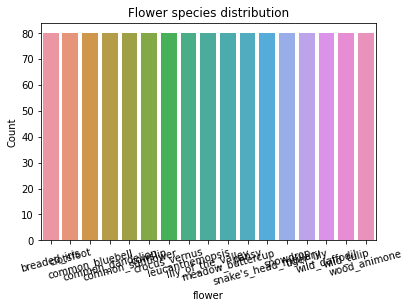

In [10]:
fig, ax = plt.subplots()
ax = sns.countplot(x="flower", data=df)
ax.set(ylabel='Count', title='Flower species distribution')
ax.tick_params(axis='x', rotation=15)

In [11]:
image_size = 224     # standard value for Transfer learning usecase (MobileNet, ResNet50, VGG16, VGG19)

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]   # load image
    img_array = np.array([img_to_array(img) for img in imgs])   # image to array 
    return(img_array)

X = np.array(read_and_prep_images(X))
print(X.shape)  

(1360, 224, 224, 3)


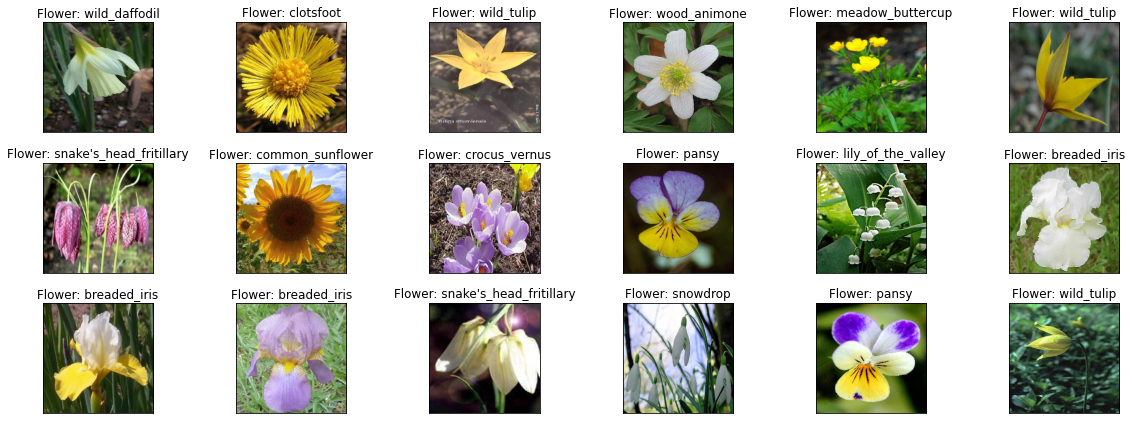

In [12]:
N = 18  # flowers to display
fig, axes = plt.subplots(3, 6, figsize=(16,6))
for ax, j in zip(axes.flat, np.random.randint(0, len(X), N)):    
    ax.imshow(X[j].astype(np.uint8))
    ax.set(title=f'Flower: {labels[y[j]]}', xticks=[], yticks=[])
fig.tight_layout()

In [13]:
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes} --> {labels}')

Number of classes: 17 --> ['breaded_iris' 'clotsfoot' 'common_bluebell' 'common_dandelion'
 'common_sunflower' 'cowslip' 'crocus_vernus' 'leucanthemopsis'
 'lily_of_the_valley' 'meadow_buttercup' 'pansy' "snake's_head_fritillary"
 'snowdrop' 'tiger_lily' 'wild_daffodil' 'wild_tulip' 'wood_animone']


In [14]:
y = to_categorical(y, num_classes)
print(y.shape)

(1360, 17)


In [15]:
#train, validation and test from the train dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, 
                                                test_size=0.25, random_state=28)

Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5,
                                            shuffle=True, random_state=28)
print(f'Train dataset: {Xtrain.shape[0]}')
print(f'Validation dataset: {Xval.shape[0]}')
print(f'Test dataset: {Xtest.shape[0]}')

Train dataset: 1020
Validation dataset: 170
Test dataset: 170


In [16]:
del X


In [17]:
del y

In [18]:
# Load the MOBILE model 
img_shape = (image_size, image_size, 3)

print('Loading MobileNetV2 ...')
model = MobileNetV2(input_shape=img_shape,
                   include_top=False,
                   weights='imagenet')
print('MobileNetV2 loaded')

model.trainable = False

model.summary()

Loading MobileNetV2 ...
9420800/9406464 [==============================] - 0s 0us/step
MobileNetV2 loaded
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1

In [19]:
model = Sequential([model,
                    GlobalAveragePooling2D(), 
                    Dense(num_classes, activation='softmax')
                   ])

#model.summary()

In [20]:
model.output_shape

(None, 17)

In [21]:
# callbacks 
weight_path = '{}_best_weights.hdf5'.format('flower')
checkpointer = ModelCheckpoint(weight_path,
                               monitor='val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=True)

# set a learning rate 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00001)
    
# early stop if not improvement of accuracy after 5 epochs
early = EarlyStopping(patience=6, 
                      verbose=1) 
    
callbacks = [checkpointer, learning_rate_reduction] #, early]

# Optimizer
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [22]:
image_size = 224
batch_size = 32
path = '/input/flowers-recognition/flowers/flowers/'


train_datagen = ImageDataGenerator(
        rescale=1./255,           
        horizontal_flip=True,     
        width_shift_range=0.2,    
        height_shift_range=0.2,   
        zoom_range=0.2)           
       

test_datagen = ImageDataGenerator(
        rescale=1./255)
        

train_gen = train_datagen.flow(
        Xtrain, ytrain, 
        batch_size=batch_size,
        shuffle=False)              

valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)   

In [23]:
batch_size = 32
epochs_0 = 20
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,  
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 1.9119 - accuracy: 0.4443
Epoch 1: val_accuracy improved from -inf to 0.67500, saving model to flower_best_weights.hdf5
31/31 [==============================] - 24s 375ms/step - loss: 1.9119 - accuracy: 0.4443 - val_loss: 1.2760 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 1.0047 - accuracy: 0.7419
Epoch 2: val_accuracy improved from 0.67500 to 0.79375, saving model to flower_best_weights.hdf5
31/31 [==============================] - 11s 348ms/step - loss: 1.0047 - accuracy: 0.7419 - val_loss: 0.8199 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.8168
Epoch 3: val_accuracy improved from 0.79375 to 0.80000, saving model to flower_best_weights.hdf5
31/31 [==============================] - 11s 348ms/step - loss: 0.6778 - accuracy: 0.8168 - val_loss: 0.6993 - val_accuracy: 0.8000 - lr: 0.

In [24]:
def plot_history(history, loss_max=5):
   
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', xlabel='epochs',
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

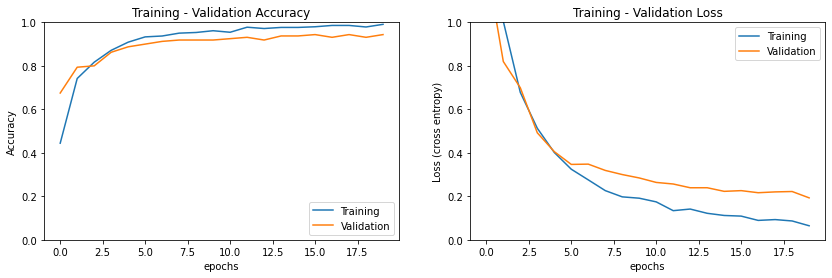

In [25]:
plot_history(history, loss_max=1)

In [26]:
datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      

# Evaluation on the test dataset
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Test loss: 0.18
Test accuracy: 94.71%


6/6 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00        12
           2       1.00      0.89      0.94         9
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        11
           5       1.00      0.79      0.88        14
           6       0.83      0.83      0.83         6
           7       1.00      1.00      1.00        10
           8       0.88      0.88      0.88         8
           9       1.00      1.00      1.00        13
          10       0.91      0.91      0.91        11
          11       1.00      1.00      1.00        11
          12       0.88      1.00      0.93         7
          13       1.00      1.00      1.00         9
          14       0.82      0.90      0.86        10
          15       0.80      0.89      0.84         9
          16       1.00      

Text(0.5, 32.09375, 'Predicted label')

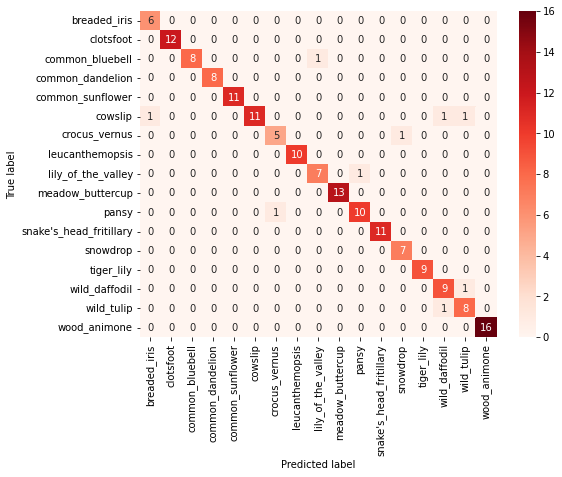

In [28]:
import seaborn as sns
from sklearn import metrics

pred = model.predict(eval_datagen, verbose=1)


y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

# confusion matrix
mat = metrics.confusion_matrix(y_true, y_pred)
df_mat = pd.DataFrame(mat, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Reds)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 0.98, 'Predicted flowers; Incorrect Labels in Red')

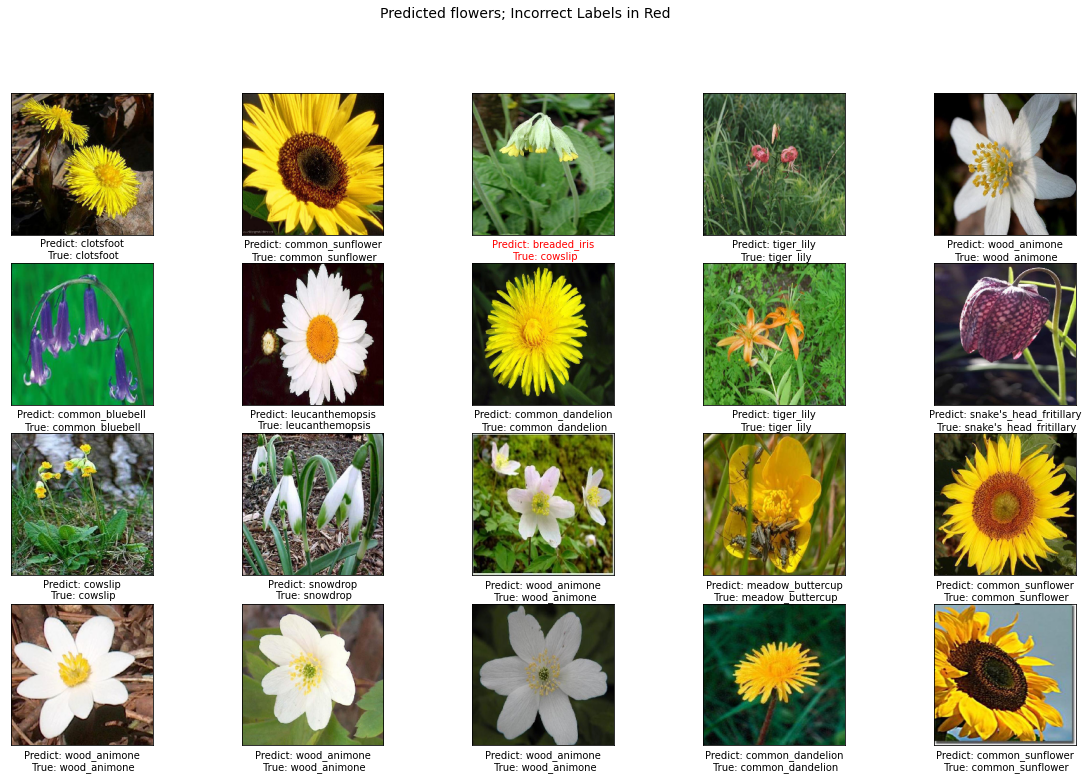

In [29]:
N = 20  # flowers to display
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].astype(np.uint8))
    ax.set(xticks=[], yticks=[])
    true = y_true[i]
    prediction = y_pred[i]   
    ax.set_xlabel(f'Predict: {labels[prediction]}\n True: {labels[true]}', 
                  color='black' if true == prediction else 'red')


fig.suptitle('Predicted flowers; Incorrect Labels in Red', size=14)

In [30]:
# Load the MOBILE model 
img_shape = (image_size, image_size, 3)

print('Loading vgg16...')
vgg16 = VGG16(input_shape=img_shape,
                   include_top=False,
                   weights='imagenet')
print('vgg16 loaded')

vgg16.trainable = False
    


Loading vgg16...
58900480/58889256 [==============================] - 0s 0us/step
vgg16 loaded


In [31]:
vgg16.output_shape


(None, 7, 7, 512)

In [32]:
vgg_model = Sequential([vgg16,
                    GlobalAveragePooling2D(), 
                    Dense(num_classes, activation='softmax')
                   ])

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 17)                8721      
                                                                 
Total params: 14,723,409
Trainable params: 8,721
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
# callbacks 
weight_path = '{}_best_weights.hdf5'.format('flower')
checkpointer = ModelCheckpoint(weight_path,
                               monitor='val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=True)

# set a learning rate 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00001)
    
# early stop if not improvement of accuracy after 5 epochs
early = EarlyStopping(patience=6, 
                      verbose=1) 
    
callbacks = [checkpointer, learning_rate_reduction] #, early]

# Optimizer
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
vgg_model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [34]:
image_size = 224
batch_size = 32
path = '/input/flowers-recognition/flowers/flowers/'


train_datagen = ImageDataGenerator(
        rescale=1./255,           
        horizontal_flip=True,     
        width_shift_range=0.2,    
        height_shift_range=0.2,   
        zoom_range=0.2)           
       

test_datagen = ImageDataGenerator(
        rescale=1./255)
        

train_gen = train_datagen.flow(
        Xtrain, ytrain, 
        batch_size=batch_size,
        shuffle=False)              

valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)   

In [35]:
batch_size = 32
epochs_0 = 20
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history = vgg_model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,  
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 2.8095 - accuracy: 0.1174
Epoch 1: val_accuracy improved from -inf to 0.23125, saving model to flower_best_weights.hdf5
31/31 [==============================] - 18s 471ms/step - loss: 2.8095 - accuracy: 0.1174 - val_loss: 2.6660 - val_accuracy: 0.2313 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 2.5850 - accuracy: 0.3128
Epoch 2: val_accuracy improved from 0.23125 to 0.40625, saving model to flower_best_weights.hdf5
31/31 [==============================] - 12s 397ms/step - loss: 2.5850 - accuracy: 0.3128 - val_loss: 2.5031 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 2.4298 - accuracy: 0.4332
Epoch 3: val_accuracy improved from 0.40625 to 0.48125, saving model to flower_best_weights.hdf5
31/31 [==============================] - 12s 395ms/step - loss: 2.4298 - accuracy: 0.4332 - val_loss: 2.3591 - val_accuracy: 0.4812 - lr: 0.

In [36]:
def plot_history(history, loss_max=5):
   
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', xlabel='epochs',
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

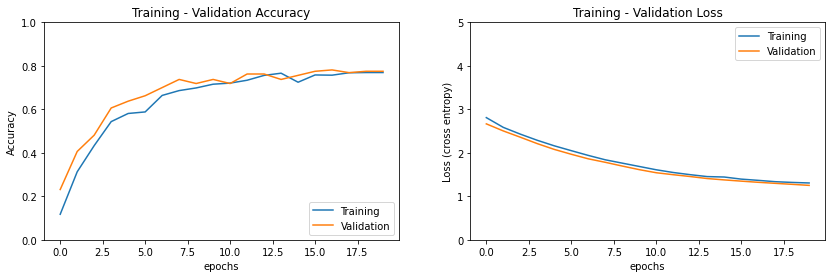

In [37]:
plot_history(history, loss_max=5)

In [42]:
datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      

# Evaluation on the test dataset
loss, acc = vgg_model.evaluate_generator(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Test loss: 1.27
Test accuracy: 73.53%


6/6 [==============================] - 2s 433ms/step
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.90      0.75      0.82        12
           2       0.54      0.78      0.64         9
           3       0.86      0.75      0.80         8
           4       1.00      1.00      1.00        11
           5       0.38      0.57      0.46        14
           6       0.62      0.83      0.71         6
           7       1.00      1.00      1.00        10
           8       0.75      0.75      0.75         8
           9       0.88      0.54      0.67        13
          10       0.80      0.73      0.76        11
          11       1.00      0.64      0.78        11
          12       0.50      0.57      0.53         7
          13       0.67      0.67      0.67         9
          14       0.78      0.70      0.74        10
          15       0.62      0.56      0.59         9
          16       0.88     

Text(0.5, 32.09375, 'Predicted label')

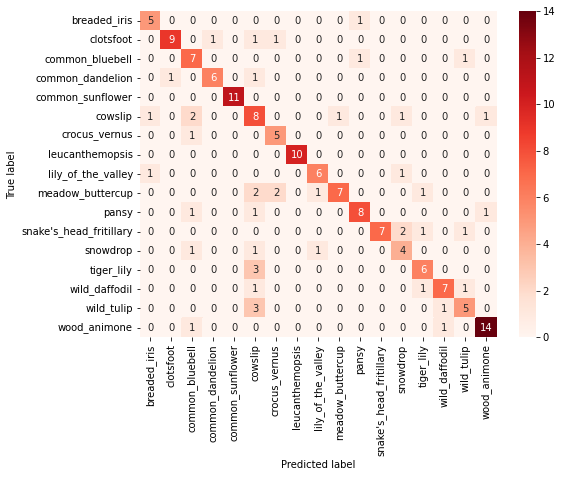

In [40]:
import seaborn as sns
from sklearn import metrics

pred = vgg_model.predict(eval_datagen, verbose=1)


y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

# confusion matrix
mat = metrics.confusion_matrix(y_true, y_pred)
df_mat = pd.DataFrame(mat, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Reds)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


Text(0.5, 0.98, 'Predicted flowers; Incorrect Labels in Red')

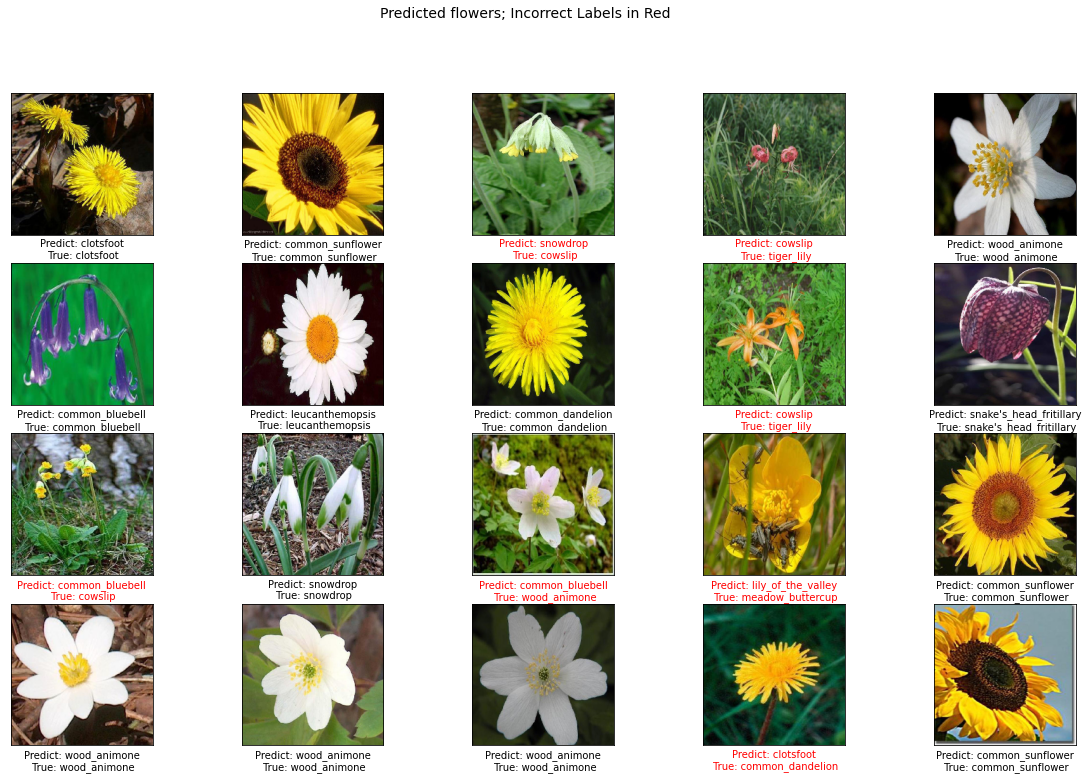

In [41]:
N = 20  # flowers to display
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].astype(np.uint8))
    ax.set(xticks=[], yticks=[])
    true = y_true[i]
    prediction = y_pred[i]   
    ax.set_xlabel(f'Predict: {labels[prediction]}\n True: {labels[true]}', 
                  color='black' if true == prediction else 'red')


fig.suptitle('Predicted flowers; Incorrect Labels in Red', size=14)